<a href="https://colab.research.google.com/github/RoBorregos/home-pipelines/blob/vision-dataset/vision/object_detector/notebooks/dataset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object detector dataset generator

With this notebook you'll be able to artificially generate and automatically label
a dataset for detecting objects. You can bring your own images or test it by fetching images from Kaggle hub.

If running on colab, install dependencies:

In [ ]:
!pip install numpy opencv-python pillow pycocotools pyyaml torch ultralytics matplotlib imutils argparse groundingdino-py segment-anything

If you want to mount your google drive for training with checkpoints in colab and saving your progress run the following cell:

In [1]:
!rm -rf /content/sample_data
!rm -rf /content/.config
from google.colab import drive
import os
drive.mount('/content', force_remount=True)
workdir = "/content/MyDrive/RoBorregos/vision/dataset_generator/"
os.makedirs(workdir, exist_ok=True)

Mounted at /content


If not mounting a drive run the next cell:

In [2]:
workdir = "/content/"

In [9]:
import os
os.chdir("/")
import sys
import random
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont, UnidentifiedImageError
from pycocotools import mask
import json
import yaml
import csv
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import ultralytics
import time
import imutils
import argparse
from segment_anything import sam_model_registry, SamPredictor
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.inference import load_model, predict
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.vl_utils import create_positive_map_from_span

# Attention!
If you have specific pictures, place the folders in ./images and skip the next two blocks of code which download a default dataset.

In [3]:
!pip install kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

In [4]:
!cp -r {dataset_path}/PetImages {workdir}
!mv {workdir}/PetImages {workdir}/images

def clean_and_trim_dataset(folder):
    total_removed = 0

    for category in ["Cat", "Dog"]:
        path = os.path.join(folder, category)
        valid_images = []

        # Step 1: Remove corrupt images
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
                valid_images.append(img_path)
            except (UnidentifiedImageError, OSError):
                os.remove(img_path)
                total_removed += 1

        print(f"Removed {total_removed} corrupt images from {category}")

        # Step 2: Remove part of the remaining valid images
        to_delete = random.sample(valid_images, len(valid_images) * 99 // 100)
        for img_path in to_delete:
            os.remove(img_path)

        print(f"Removed {len(to_delete)} images from {category} to reduce dataset size")

clean_and_trim_dataset(workdir + "images")

def count_files_in_dir(directory):
    # List all files (images) in the directory and count them
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Example usage for "Cat" and "Dog" folders
cat_folder = workdir + "images/Cat"
dog_folder = workdir + "images/Dog"

print(f"Number of cat images: {count_files_in_dir(cat_folder)}")
print(f"Number of dog images: {count_files_in_dir(dog_folder)}")

Removed 0 corrupt images from Cat
Removed 12374 images from Cat to reduce dataset size


/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed 0 corrupt images from Dog
Removed 12374 images from Dog to reduce dataset size
Number of cat images: 125
Number of dog images: 125


## Resize images

In [5]:
base_path = workdir + "images"
size = 720

for class_dir in os.listdir(base_path):
    class_path = os.path.join(base_path, class_dir)

    if not os.path.isdir(class_path):
        continue

    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)

        try:
            with Image.open(file_path) as img:
                img = img.resize((size, size))
                img.save(file_path)
        except (UnidentifiedImageError, OSError) as e:
            print(f"Removing corrupt file: {file_path}")
            os.remove(file_path)  # delete corrupt image

os.chdir(workdir)

## Download models

If you have already ran this and are using a volume/drive there is no need to run again.

In [6]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 3.26 MiB/s, done.
Resolving deltas: 100% (241/241), done.
--2025-04-23 01:53:44--  https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/611591640/f221e500-c2fc-4fd3-b84e-8ad92a6923f3?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20250423%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20250423T015345Z&X-Amz-Expires=300&X-Amz-Signature=54b0ad6a35993145c603f0973ae416b

## Segment images

In [7]:
SAVE_BB = False
DEBUG = False

results_path = workdir + "processed" #path to save results already processed and segmented images
config_file = workdir + "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"  # change the path of the model config file
checkpoint_path = workdir + "groundingdino_swint_ogc.pth"  # change the path of the model
output_dir = results_path
box_threshold = 0.3
text_threshold = 0.25
token_spans = None

sys.path.append("..")
sam_model = "h"

#use sam model
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
if sam_model =="h":
  sam_checkpoint = workdir + "sam_vit_h_4b8939.pth"
  model_type = "vit_h"
else:
  sam_checkpoint = workdir + "sam_vit_l_0b3195.pth"
  model_type = "vit_l"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

images=[]
annotations=[]
categories=[]

img_id=0
anno_id=0

# Make a list of all the directories in the path
base_path = workdir + "images"
path_to_classes = [f.path for f in os.scandir(base_path) if f.is_dir()]

def load_image(image_path):

    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def load_model(model_config_path, model_checkpoint_path, cpu_only=False):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    if DEBUG:
        print(load_res)
    _ = model.eval()
    return model


def get_grounding_output(model, image, caption, box_threshold, text_threshold=None, with_logits=True, cpu_only=False, token_spans=None):
    assert text_threshold is not None or token_spans is not None, "text_threshould and token_spans should not be None at the same time!"
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        if DEBUG:
            print("Running model...")
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"][0]  # (nq, 4)

    # filter output
    if token_spans is None:
        logits_filt = logits.cpu().clone()
        boxes_filt = boxes.cpu().clone()
        filt_mask = logits_filt.max(dim=1)[0] > box_threshold
        logits_filt = logits_filt[filt_mask]  # num_filt, 256
        boxes_filt = boxes_filt[filt_mask]  # num_filt, 4

        # get phrase
        tokenlizer = model.tokenizer
        tokenized = tokenlizer(caption)
        # build pred
        pred_phrases = []
        for logit, box in zip(logits_filt, boxes_filt):
            pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
            if with_logits:
                pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
            else:
                pred_phrases.append(pred_phrase)
    else:
        # given-phrase mode
        positive_maps = create_positive_map_from_span(
            model.tokenizer(text_prompt),
            token_span=token_spans
        ).to(image.device) # n_phrase, 256

        logits_for_phrases = positive_maps @ logits.T # n_phrase, nq
        all_logits = []
        all_phrases = []
        all_boxes = []
        for (token_span, logit_phr) in zip(token_spans, logits_for_phrases):
            # get phrase
            phrase = ' '.join([caption[_s:_e] for (_s, _e) in token_span])
            # get mask
            filt_mask = logit_phr > box_threshold
            # filt box
            all_boxes.append(boxes[filt_mask])
            # filt logits
            all_logits.append(logit_phr[filt_mask])
            if with_logits:
                logit_phr_num = logit_phr[filt_mask]
                all_phrases.extend([phrase + f"({str(logit.item())[:4]})" for logit in logit_phr_num])
            else:
                all_phrases.extend([phrase for _ in range(len(filt_mask))])
        boxes_filt = torch.cat(all_boxes, dim=0).cpu()
        pred_phrases = all_phrases
    return boxes_filt, pred_phrases


def verify_or_create_dir(path):
    os.makedirs(path, exist_ok=True)
    if DEBUG:
        print(f"Verified/created: {path}")


def count_all_files_in_dir(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len([f for f in files if os.path.isfile(os.path.join(root, f))])
    return count


# Get total number of images to process
image_dir = workdir + "images"
number_of_images = count_all_files_in_dir(image_dir)
print(f"Total image files: {number_of_images}")

# Check if results directory exists, else create it
verify_or_create_dir(results_path)

# Main loop
i = 0
for class_path in path_to_classes:
    imgPaths = os.listdir(class_path)
    if SAVE_BB:
        class_name = os.path.basename(class_path)
        verify_or_create_dir(f"{results_path}/bbs/{class_name}")

    for imgPath in imgPaths:
        if DEBUG:
            print(f"Processing image: {imgPath}")
        print(f"%{i * 100 / number_of_images}")
        img = imutils.resize(cv2.imread(f"{class_path}/{imgPath}"))
        if img is None:
            continue

    #------------------------start grounding----------------------------------------------

        # Image_path = args.image_path
        cpu_only = False if torch.cuda.is_available() else True

        # Load image
        image_pil, image = load_image(f"{class_path}/{imgPath}")

        # Load model
        model = load_model(config_file, checkpoint_path, cpu_only=cpu_only)

        # Set the text_threshold to None if token_spans is set.
        if token_spans is not None:
            text_threshold = None
            print("Using token_spans. Set the text_threshold to None.")

        # Run model
        text_prompt = os.path.basename(class_path)
        boxes_filt, pred_phrases = get_grounding_output(
            model, image, text_prompt, box_threshold, text_threshold, cpu_only=cpu_only, token_spans=eval(f"{token_spans}")
        )

        # Found bb dimensions

        size = image_pil.size
        pred_dict = {
            "boxes": boxes_filt,
            "size": [size[1], size[0]],  # H, W
            "labels": pred_phrases,
        }

        H, W = pred_dict["size"]
        boxes = pred_dict["boxes"]
        labels = pred_dict["labels"]
        assert len(boxes) == len(labels), "boxes and labels must have same length"

        draw = ImageDraw.Draw(image_pil)
        mask = Image.new("L", image_pil.size, 0)
        mask_draw = ImageDraw.Draw(mask)

        #change pil image to cv2 image
        img = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
        img2 = img.copy()
        # draw boxes and masks
        for box, label in zip(boxes, labels):
            # from 0..1 to 0..W, 0..H
            box = box * torch.Tensor([W, H, W, H])
            # from xywh to xyxy
            box[:2] -= box[2:] / 2
            box[2:] += box[:2]
            # random color
            color = tuple(np.random.randint(0, 255, size=1).tolist())
            # draw
            padding = 10
            x0, y0, x1, y1 = box
            x0, y0, x1, y1 = int(x0)-padding, int(y0)-padding, int(x1)+padding, int(y1)+padding

            #validate if the bounding box is inside the image
            if x0 < 0:
                x0 = 0
            if y0 < 0:
                y0 = 0
            if x1 > W:
                x1 = W
            if y1 > H:
                y1 = H

            #draw rectangles
            cv2.rectangle(img2, (x0, y0), (x1, y1), color, 2)

            draw.rectangle([x0, y0, x1, y1], outline=color, width=6)
            # draw.text((x0, y0), str(label), fill=color)

            font = ImageFont.load_default()
            if hasattr(font, "getbbox"):
                bbox = draw.textbbox((x0, y0), str(label), font)
            else:
                w, h = draw.textsize(str(label), font)
                bbox = (x0, y0, w + x0, y0 + h)
            # bbox = draw.textbbox((x0, y0), str(label))
            draw.rectangle(bbox, fill=color)
            draw.text((x0, y0), str(label), fill="white")

            mask_draw.rectangle([x0, y0, x1, y1], fill=255, width=6)

    # ----------------Start SAM--------------------------------------------------------------

            class_name = class_path.split("/")[-1]
            sam_bounding_box = np.array([x0, y0, x1, y1])
            ran_sam = False
            #run sam
            if ran_sam == False:
                predictor.set_image(img)
                ran_sam = True

            mask, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=sam_bounding_box,
                multimask_output=False,
            )

            mask, _, _ = predictor.predict(box=sam_bounding_box, multimask_output=False)

            # Make png mask
            contours, _ = cv2.findContours(mask[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Your call to find the contours

            # threshold input image using otsu thresholding as mask and refine with morphology
            ret, pngmask = cv2.threshold(mask[0].astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            kernel = np.ones((9,9), np.uint8)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_CLOSE, kernel)
            pngmask = cv2.morphologyEx(pngmask, cv2.MORPH_OPEN, kernel)
            result = img.copy()
            result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
            result[:, :, 3] = pngmask

    # ----------------Save Images-----------------------------------------------------------------

            if SAVE_BB:
              cv2.imwrite(f"{results_path}/bbs/{class_name}/{imgPath}", img2)

            verify_or_create_dir(f"{results_path}/{class_name}")

            file_path = f"{results_path}/{class_name}/{imgPath[:-4]}.png"
            if os.path.exists(file_path):
                if os.path.exists(f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"):
                    if DEBUG:
                        print("File already exists, saving with _2")
                    cv2.imwrite(f"{results_path}/{class_name}/{imgPath[:-4]}_2.png", result)
                else:
                    if DEBUG:
                        print("File already exists, saving with _1")
                    file_path = f"{results_path}/{class_name}/{imgPath[:-4]}_1.png"

            cv2.imwrite(file_path, result)
            i = i + 1
            ran_sam = False

Using cuda
Total image files: 229
%0.0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1575: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `

%0.4366812227074236
final text_encoder_type: bert-base-uncased
%0.8733624454148472
final text_encoder_type: bert-base-uncased
%1.3100436681222707
final text_encoder_type: bert-base-uncased
%1.7467248908296944
final text_encoder_type: bert-base-uncased
%2.183406113537118
final text_encoder_type: bert-base-uncased
%2.6200873362445414
final text_encoder_type: bert-base-uncased
%3.056768558951965
final text_encoder_type: bert-base-uncased
%3.493449781659389
final text_encoder_type: bert-base-uncased
%3.930131004366812
final text_encoder_type: bert-base-uncased
%4.366812227074236
final text_encoder_type: bert-base-uncased
%4.366812227074236
final text_encoder_type: bert-base-uncased
%4.8034934497816595
final text_encoder_type: bert-base-uncased
%5.240174672489083
final text_encoder_type: bert-base-uncased
%5.676855895196507
final text_encoder_type: bert-base-uncased
%6.11353711790393
final text_encoder_type: bert-base-uncased
%6.550218340611353
final text_encoder_type: bert-base-uncased
%6.

## Manually check segmented images

Press k to keep an images or d to delete it. You may also use the buttons.

In [5]:
import os
from IPython.display import display, Image, Javascript, clear_output
import ipywidgets as widgets

# Step 1: Collect image paths
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')
image_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk('/content/processed')
    for file in files if file.lower().endswith(image_extensions)
]

# Step 2: Create widgets
output = widgets.Output()
hidden_input = widgets.Text(placeholder='Press k (keep) or d (delete)', layout=widgets.Layout(width='0px'))
keep_button = widgets.Button(description="Keep", button_style='success')
delete_button = widgets.Button(description="Delete", button_style='danger')

# Step 3: State management
index = {"i": 0}

def show_image():
    output.clear_output(wait=True)
    if index["i"] < len(image_paths):
        with output:
            display(Image(filename=image_paths[index["i"]], width=400))
            display(widgets.HBox([keep_button, delete_button]))
            hidden_input.value = ''  # Clear input for next key
            hidden_input.focus()
    else:
        with output:
            print("✅ All images reviewed!")

def keep_image(_=None):
    index["i"] += 1
    show_image()

def delete_image(_=None):
    try:
        os.remove(image_paths[index["i"]])
        print(f"🗑️ Deleted: {image_paths[index['i']]}")
    except Exception as e:
        print(f"⚠️ Error deleting file: {e}")
    index["i"] += 1
    show_image()

def handle_keypress(change):
    key = change["new"].lower()
    if key == 'k':
        keep_image()
    elif key == 'd':
        delete_image()

# Step 4: Bind events
keep_button.on_click(keep_image)
delete_button.on_click(delete_image)
hidden_input.observe(handle_keypress, names='value')

# Step 5: Inject JavaScript to forward keypresses to the hidden text widget
js_focus = Javascript("""
document.addEventListener("keydown", (e) => {
    const input = document.querySelector('input[placeholder="Press k (keep) or d (delete)"]');
    if (input) {
        input.value = e.key;
        input.dispatchEvent(new Event('input', { bubbles: true }));
    }
});
""")

# Step 6: Display everything
display(widgets.HTML("<b>Use 'k' to Keep, 'd' to Delete</b>"))
display(hidden_input)
display(js_focus)
display(output)
show_image()


HTML(value="<b>Use 'k' to Keep, 'd' to Delete</b>")

Text(value='', layout=Layout(width='0px'), placeholder='Press k (keep) or d (delete)')

<IPython.core.display.Javascript object>

Output()

## Setup for dataset generation

In [10]:
results_path = workdir + "DS_res/"
path_to_classes = [f.path for f in os.scandir(workdir + "processed") if f.is_dir()]

for class_path in path_to_classes:
    class_name = os.path.basename(class_path)
    verify_or_create_dir(results_path + class_name)
    for file_name in os.listdir(class_path):
        try:
            file_path = class_path + "/" + file_name
            my_image = Image.open(file_path)
            black = Image.new('RGBA', my_image.size)
            my_image = Image.composite(my_image, black, my_image)
            cropped_image = my_image.crop(my_image.getbbox())
            cropped_image.save(f"{results_path}{class_name}/{file_name}")
            print(f"{file_name} done")
        except Exception as e:
            print(f"{file_name} failed {e}")
            continue

20250422_191908_005.png done
20250422_191908_018.png done
20250422_191912_037.png done
20250422_191908_015.png done
20250422_191912_034.png done
20250422_191908_012.png done
20250422_191912_012.png done
20250422_191912_010.png done
20250422_191908_030.png done
20250422_191908_003.png done
20250422_191912_015.png done
20250422_191912_003.png done
20250422_191912_038.png done
20250422_191912_007.png done
20250422_191908_006.png done
20250422_191912_040.png done
20250422_191908_007.png done
20250422_191912_005.png done
20250422_191912_016.png done
20250422_191912_004.png done
20250422_191912_013.png done
20250422_191912_035.png done
20250422_191912_014.png done
20250422_191908_008.png done
20250422_191908_027.png done
20250422_191912_006.png done
20250422_191912_026.png done
20250422_191908_004.png done
20250422_191912_009.png done
20250422_191908_009.png done
20250422_191912_027.png done
20250422_191908_002.png done
20250422_191912_002.png done
20250422_191912_001.png done
20250422_19190

In [11]:
# Get all subfolders inside results_path
path_to_classes = [f.path for f in os.scandir(results_path) if f.is_dir() and "bbs" not in f.name]

# Build list of (path, class_name) tuples
fg_folders = [(path, os.path.basename(path)) for path in path_to_classes]

# Define folders
bg_folder = workdir + "bg/"
verify_or_create_dir(bg_folder)
output_folder = workdir + "ds_final/"

In [12]:
objects_list = [os.path.basename(class_path) for class_path in path_to_classes]
annotations_ID = {}
categories = []
for i, object in enumerate(objects_list):
    annotations_ID[object] = i
    categories.append({"id": i, "name": object})

print(annotations_ID)
print(categories)

{'Soap': 0, 'Can': 1, 'Box': 2}
[{'id': 0, 'name': 'Soap'}, {'id': 1, 'name': 'Can'}, {'id': 2, 'name': 'Box'}]


In [13]:
# Load the list of files in each of the three folders
fg_files = {}
for folder, category in fg_folders:
    fg_files[category] = os.listdir(folder)

In [14]:
# Define the folder structure
subfolders = [
    "train/images",
    "train/labels",
    "test/images",
    "test/labels",
    "valid/images",
    "valid/labels",
]

# Create them
for sub in subfolders:
    verify_or_create_dir(os.path.join(output_folder, sub))

# Autolabel

For this step, add background images to ./bg

You can run the next cell to download and format a default dataset.

In [15]:
!pip install kagglehub
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("balraj98/stanford-background-dataset")

os.system(f'cp "{dataset_path}/images/"* {workdir}bg/')

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com


100%|██████████| 17.1M/17.1M [00:01<00:00, 17.0MB/s]

Extracting files...


0

## Remove corrupt images

You con also remove a percentage of images by modifying *delete_percentage*

In [16]:
delete_percentage = 0

def clean_and_trim_dataset(folder):
    total_removed = 0
    valid_images = []

    # Step 1: Remove corrupt images
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if not os.path.isfile(img_path):
            continue
        try:
            with Image.open(img_path) as img:
                img.verify()
            valid_images.append(img_path)
        except (UnidentifiedImageError, OSError):
            os.remove(img_path)
            total_removed += 1

    print(f"Removed {total_removed} corrupt images")

    # Step 2: Remove part of the remaining valid images
    to_delete = random.sample(valid_images, len(valid_images) * delete_percentage)
    for img_path in to_delete:
        os.remove(img_path)

    print(f"Removed {len(to_delete)} images to reduce dataset size")

def count_files_in_dir(directory):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Apply on /content/bg
clean_and_trim_dataset(workdir + "bg")

# Count remaining images
print(f"Remaining number of images: {count_files_in_dir(workdir + 'bg')}")


Removed 0 corrupt images
Removed 0 images to reduce dataset size
Remaining number of images: 715


## Image generator

This cell takes the segmented images of the classes and backgrounds and generate images with a random amount of objects in them scattered around.

In [17]:
images = []
annotations = []
annotations2 = []
annot_csv = []

img_id = int(0)
anno_id = int(0)

# Ratios at which these values will be modified
brightness_ratio = 0.05
saturation_ratio = 0.05
hue_ratio = 0.02
rescaling_min = 0.30
rescaling_max = 0.40

# Define the maximum overlap as a percentage
max_overlap_pct = 5

trainfolder = output_folder + "train/"
validfolder = output_folder + "valid/"

images_to_generate = 1500
max_objects_per_image = 5

for j in range(images_to_generate):
    with open(f'{trainfolder}labels/{img_id}.txt', 'w') as file:
        pass

    num_objects = random.randint(1, max_objects_per_image)
    fg_categories = random.choices(objects_list, k=num_objects)

    fg_files_selected = [[category, random.choice(fg_files[category])] for category in fg_categories]

    fg_imgs = []
    for img in fg_files_selected:
        folder = [f[0] for f in fg_folders if f[1] == img[0]][0]
        fg_imgs.append([img[0], Image.open(folder + "/" + img[1]), folder + img[1]])

    bg_files = os.listdir(bg_folder)
    bg_file = random.choice(bg_files)
    bg_img = Image.open(bg_folder + bg_file)

    occupied_mask = np.zeros((bg_img.height, bg_img.width), dtype=np.uint8)

    for img in fg_imgs:
        fg_img = img[1]

        angle = random.randint(-5, 5)
        scale = random.uniform(rescaling_min, rescaling_max)
        fg_img = fg_img.rotate(angle, resample=Image.BICUBIC, expand=True)
        fg_img = fg_img.resize((int(fg_img.width * scale), int(fg_img.height * scale)))

        MAX_OBJ_WIDTH = bg_img.width * 0.25
        MAX_OBJ_HEIGHT = bg_img.height * 0.25

        if fg_img.width > MAX_OBJ_WIDTH or fg_img.height > MAX_OBJ_HEIGHT:
            aspect_ratio = fg_img.width / fg_img.height
            if aspect_ratio >= 1:
                fg_img = fg_img.resize((int(MAX_OBJ_WIDTH), int(MAX_OBJ_WIDTH / aspect_ratio)))
            else:
                fg_img = fg_img.resize((int(MAX_OBJ_HEIGHT * aspect_ratio), int(MAX_OBJ_HEIGHT)))

        fg_img = ImageEnhance.Brightness(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = ImageEnhance.Contrast(fg_img).enhance(random.uniform(0.9, 1.1))
        fg_img = ImageEnhance.Color(fg_img).enhance(random.uniform(0.7, 1.3))
        fg_img = fg_img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.0, 0.5)))

        img[1] = fg_img

        max_x = bg_img.width - fg_img.width
        max_y = bg_img.height - fg_img.height

        for attempt in range(50):
            x = random.randint(0, max_x)
            y = random.randint(0, max_y)

            fg_mask = np.array(fg_img.split()[-1]) > 0
            occ_crop = occupied_mask[y:y + fg_img.height, x:x + fg_img.width]
            overlap = np.sum(np.logical_and(fg_mask, occ_crop))
            allowed_overlap = max_overlap_pct / 100 * np.sum(fg_mask)

            if overlap <= allowed_overlap:
                occupied_mask[y:y + fg_img.height, x:x + fg_img.width] = np.logical_or(occ_crop, fg_mask)
                break
        else:
            continue

        seg_img = fg_img
        img_arr = np.array(seg_img)
        mask = img_arr[:, :, 3] != 0

        segmentation = []
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i, j]:
                    segmentation.append(j + x)
                    segmentation.append(i + y)
        segmentation = [segmentation]

        area = abs(sum(
            segmentation[0][2 * i] * segmentation[0][(2 * i + 3) % len(segmentation[0])] -
            segmentation[0][(2 * i + 2) % len(segmentation[0])] * segmentation[0][2 * i + 1]
            for i in range(len(segmentation[0]) // 2)
        )) / 2

        bg_img.paste(fg_img, (x, y), fg_img)

        x1, y1 = x, y
        x2 = x + fg_img.width
        y2 = y + fg_img.height

        if x2 <= x1 or y2 <= y1:
            continue

        x_center_ann = ((x1 + x2) / 2) / bg_img.width
        y_center_ann = ((y1 + y2) / 2) / bg_img.height
        width_ann = (x2 - x1) / bg_img.width
        height_ann = (y2 - y1) / bg_img.height

        if not (0 <= x_center_ann <= 1 and 0 <= y_center_ann <= 1 and 0 <= width_ann <= 1 and 0 <= height_ann <= 1):
            continue

        with open(f'{trainfolder}labels/{img_id}.txt', 'a') as f:
            f.write(f"{annotations_ID[img[0]]} {x_center_ann} {y_center_ann} {width_ann} {height_ann}\n")

        annotations2.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": segmentation, "area": area, "iscrowd": 0
        })
        annotations.append({
            "id": anno_id, "image_id": img_id, "category_id": annotations_ID[img[0]],
            "bbox": [x, y, fg_img.width, fg_img.height],
            "segmentation": [], "area": fg_img.height * fg_img.width, "iscrowd": 0
        })
        annot_csv.append([
            "TRAIN", output_folder + str(img_id)+".jpg", img[0], x/bg_img.width, y/bg_img.height,
            "", "", (x+fg_img.width)/bg_img.width, (y+fg_img.height)/bg_img.height
        ])

        anno_id += 1

    bg_img.save(f"{trainfolder}images/" + str(img_id) + ".jpg", quality=100)
    images.append({"id": img_id, "file_name": str(img_id) + ".jpg", "height": bg_img.height, "width": bg_img.width})
    img_id += 1

# Create data.yaml
data = dict(
    train=f"{trainfolder}images",
    val=f"{validfolder}images",
    test=f"{validfolder}images",
    nc=len(annotations_ID),
    names=list(annotations_ID.keys())
)

with open(f'{output_folder}data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)


## Check generated images

This cell shows 5 random images from the dataset and draws the bounding boxes from the labels.

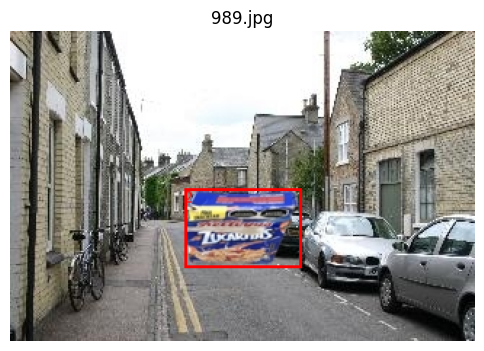

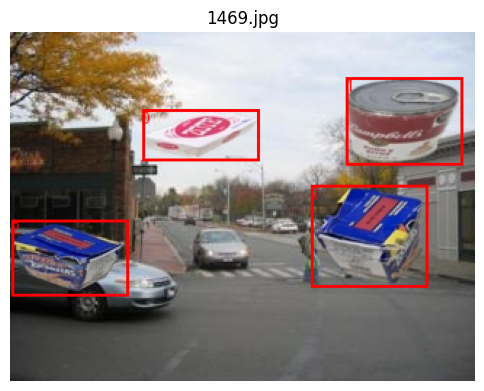

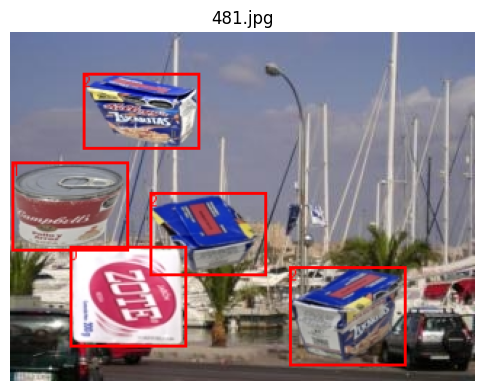

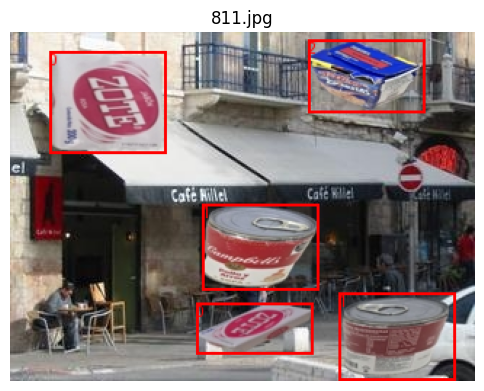

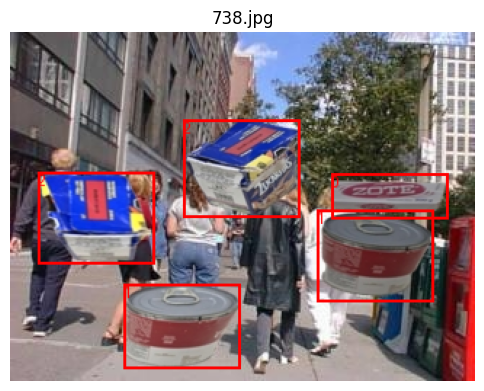

In [19]:
# === CONFIG ===
images_dir = workdir + "ds_final/train/images"
labels_dir = workdir + "ds_final/train/labels"
num_samples = 5

# Get all image files
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
sampled_files = random.sample(image_files, min(num_samples, len(image_files)))

for image_file in sampled_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(labels_dir, label_file)

    # Load image
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()

        for label in labels:
            cls, x_center, y_center, w, h = map(float, label.strip().split())
            x_center *= img_width
            y_center *= img_height
            w *= img_width
            h *= img_height
            x0 = x_center - w / 2
            y0 = y_center - h / 2
            x1 = x_center + w / 2
            y1 = y_center + h / 2
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
            draw.text((x0, y0), str(int(cls)), fill="red")

    # Show image with bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis("off")
    plt.show()

## Split images

Take a percentage of the images and move them to test and validation directories.

In [20]:
import os
import shutil
import random

validation = 0.1
test = 0.1

# Assumes test has 100% of data
output_folder = workdir + "/ds_final/"
trainfolder = output_folder + "train/"
trainfolderimgs = trainfolder + "images/"
trainfolderlabels = trainfolder + "labels/"
testfolder = output_folder + "test/"
testfolderimgs = testfolder + "images/"
testfolderlabels = testfolder + "labels/"
validfolder = output_folder + "valid/"
validfolderimgs = validfolder + "images/"
validfolderlabels = validfolder + "labels/"

fullSize = len(os.listdir(trainfolderimgs))
validSize = int(fullSize * validation)
testSize = int(fullSize * test)

for i in range(validSize):
    filelist = os.listdir(trainfolderimgs)
    #randomize file list, to not pick files in order
    random.shuffle(filelist)
    filetomove = filelist[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{validfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{validfolderlabels}{filetomovename}.txt")
for i in range(testSize):
    filetomove = os.listdir(trainfolderimgs)[i]
    #take out .jpg, .png, etc
    filetomovename = filetomove[:-4]
    #move images
    shutil.move(f"{trainfolderimgs}{filetomove}", f"{testfolderimgs}{filetomove}")
    #move labels
    shutil.move(f"{trainfolderlabels}{filetomovename}.txt", f"{testfolderlabels}{filetomovename}.txt")

#Validation
print(f"Train size is now: {len(os.listdir(trainfolderimgs))}")
print(f"Validation size is now: {len(os.listdir(validfolderimgs))}")
print(f"Test size is now: {len(os.listdir(testfolderimgs))}")

Train size is now: 1200
Validation size is now: 150
Test size is now: 150


## Train a yolo model with the dataset

Clean invalid labels and then train yolo.

In [21]:
def clean_labels(split):
    label_dir = f'{workdir}ds_final/{split}/labels'
    if not os.path.exists(label_dir):
        print(f"Label directory for {split} not found.")
        return

    for label_file in os.listdir(label_dir):
        path = os.path.join(label_dir, label_file)
        with open(path, 'r') as f:
            lines = f.readlines()

        valid_lines = []
        for line in lines:
            try:
                parts = list(map(float, line.strip().split()))
                if len(parts) == 5:
                    _, x, y, w, h = parts
                    if all(0 <= val <= 1 for val in [x, y, w, h]):
                        valid_lines.append(line)
            except Exception as e:
                print(f"Error parsing line in {label_file}: {line} -> {e}")

        if valid_lines:
            with open(path, 'w') as f:
                f.writelines(valid_lines)
        else:
            os.remove(path)
            print(f"❌ Removed invalid label file: {path}")

# Clean labels for all splits
for split in ['train', 'test', 'valid']:
    print(f"🧹 Cleaning {split} labels...")
    clean_labels(split)

print("✅ Done cleaning labels!")


🧹 Cleaning train labels...
🧹 Cleaning test labels...
🧹 Cleaning valid labels...
✅ Done cleaning labels!


In [ ]:
!pip install ultralytics
from ultralytics import YOLO

import os
os.chdir(workdir)

# Load a YOLOv8 model (you can also use 'yolov8n.yaml', 'yolov8s.yaml', etc.)
model = YOLO("yolov8m.yaml")

# Train the model
model.train(
    data=workdir + "ds_final/data.yaml",
    epochs=120,
    imgsz=640,
    batch=16,
    perspective=0.001,
    scale=0.7,
    translate=0.1,
    degrees=10,
    shear=2,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.3
)

Looking in indexes: http://jetson.webredirect.org/jp6/cu126, https://pypi.ngc.nvidia.com
New https://pypi.org/project/ultralytics/8.3.115 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.113 🚀 Python-3.10.12 torch-2.4.0 CUDA:0 (Orin, 62841MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/ds_final/data.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, clas

100%|██████████| 5.35M/5.35M [00:00<00:00, 18.4MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1049.1±539.0 MB/s, size: 51.1 KB)


train: Scanning /content/ds_final/train/labels.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 451.3±246.7 MB/s, size: 43.4 KB)


val: Scanning /content/ds_final/valid/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      6.42G      3.026      3.295      3.809         72        640: 100%|██████████| 75/75 [00:53<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]

                   all        150        436   3.66e-05    0.00219   1.84e-05   3.69e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      7.29G      2.355      2.008       2.88         88        640: 100%|██████████| 75/75 [00:50<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]

                   all        150        436      0.592      0.568      0.648      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      7.29G      2.014      1.656       2.48        135        640: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        150        436      0.741      0.755      0.862      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      7.29G       1.83      1.407      2.275        116        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        150        436      0.907      0.879      0.978      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      7.29G      1.666      1.226      2.104        109        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        150        436       0.76      0.763      0.931      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      7.29G      1.611      1.134      2.011        121        640: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        150        436       0.95       0.87      0.965      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      7.29G      1.456      1.005      1.861         87        640: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.973      0.964      0.985       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      7.29G      1.382     0.9159      1.787         92        640: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.988      0.997      0.995      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      7.29G      1.338     0.8877      1.758        108        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.956       0.97      0.984      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      7.29G      1.349     0.8574      1.763         83        640: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]

                   all        150        436      0.985      0.998      0.995      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      7.29G      1.323     0.8471      1.714        138        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.988       0.98      0.992      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120      7.29G      1.262     0.7722      1.669         93        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        150        436      0.994          1      0.995      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      7.29G      1.231     0.7506       1.64        113        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.993      0.995      0.994      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      7.29G      1.189     0.7141      1.603         71        640: 100%|██████████| 75/75 [00:48<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        150        436      0.991      0.992      0.995      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      7.29G      1.178     0.6858      1.578         95        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        150        436      0.996      0.997      0.995      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      7.29G      1.163     0.6804      1.565        100        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.996      0.997      0.995      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      7.29G      1.124     0.6521      1.536         89        640: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.998          1      0.995      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      7.29G      1.125     0.6431      1.547        118        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        150        436      0.996      0.997      0.995      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      7.29G      1.095     0.6165      1.513        105        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

                   all        150        436      0.998          1      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      7.29G      1.083     0.6122      1.502        102        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

                   all        150        436      0.993          1      0.995      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      7.29G      1.042     0.5967      1.461         72        640: 100%|██████████| 75/75 [00:49<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.998          1      0.995      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      7.29G      1.086     0.6147      1.504         88        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.998      0.998      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120      7.29G       1.03      0.573      1.452        104        640: 100%|██████████| 75/75 [00:49<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

                   all        150        436      0.998          1      0.995      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      7.29G     0.9761     0.5291      1.426        100        640:   4%|▍         | 3/75 [00:02<00:48,  1.50it/s]

In [6]:
# Test the model
#model.val(data="ds_final/data.yaml", split="test")

# Load the best trained model
model = YOLO(workdir + "notebooks/runs/detect/train/weights/best.pt")

# Run inference on test images
results = model.predict(source=workdir + "ds_final/test/images", save=True, conf=0.25)


image 1/14 /content/test/20250423_120416.jpg: 640x320 1 Box, 23.8ms
image 2/14 /content/test/20250423_120418.jpg: 640x320 1 Box, 22.8ms
image 3/14 /content/test/20250423_120420.jpg: 640x320 (no detections), 22.7ms
image 4/14 /content/test/20250423_120422.jpg: 640x320 1 Box, 22.7ms
image 5/14 /content/test/20250423_120429.jpg: 640x320 (no detections), 22.8ms
image 6/14 /content/test/20250423_120431.jpg: 640x320 (no detections), 22.5ms
image 7/14 /content/test/20250423_120432.jpg: 640x320 1 Soap, 22.6ms
image 8/14 /content/test/20250423_120436.jpg: 640x320 1 Soap, 22.7ms
image 9/14 /content/test/20250423_120437.jpg: 640x320 (no detections), 22.6ms
image 10/14 /content/test/20250423_120439.jpg: 640x320 1 Soap, 22.6ms
image 11/14 /content/test/20250423_120441.jpg: 640x320 (no detections), 22.5ms
image 12/14 /content/test/20250423_120443.jpg: 640x320 1 Box, 22.5ms
image 13/14 /content/test/20250423_120447.jpg: 640x320 (no detections), 22.7ms
image 14/14 /content/test/20250423_120450.jpg: 6